In [25]:
import pandas as pd
import numpy as np

# 1. Load the data
gas_df = pd.read_csv("datathon data/weekly_gasoline_prices.csv")
ev_df = pd.read_csv("datathon data/Filtered_EV_Stock_Data_Truncated_4dp_From_2018-09-12.csv")
auto_df = pd.read_csv("datathon data/Filtered_Traditional_Auto_Stock_Data_Truncated_4dp_From_2018-09-12.csv")
brent_df = pd.read_csv("datathon data/crude_oil/BRENT.csv")

# 2. Parse dates
for df in (ev_df, auto_df, gas_df, brent_df):
    df["Date"] = pd.to_datetime(df["Date"])

# 3. Drop duplicate dates in each
ev_df = ev_df.drop_duplicates(subset="Date")
auto_df = auto_df.drop_duplicates(subset="Date")
gas_df = gas_df.drop_duplicates(subset="Date")
brent_df = brent_df.drop_duplicates(subset="Date")

# 4. Set Date as index and sort
ev_df = ev_df.set_index("Date").sort_index()
auto_df = auto_df.set_index("Date").sort_index()

gas_df = gas_df[["Date", "Price"]].rename(columns={"Price": "Gasoline_Price"}).set_index("Date").sort_index()
brent_df = brent_df[["Date", "Price"]].rename(columns={"Price": "Brent_Price"}).set_index("Date").sort_index()

# 5. Create a business-day index
start = max(ev_df.index.min(), auto_df.index.min())
end   = min(ev_df.index.max(), auto_df.index.max())
bidx  = pd.date_range(start=start, end=end, freq="B")

# 6. Reindex & forward‑fill gasoline & brent
gas_daily   = gas_df.reindex(bidx).ffill()
brent_daily = brent_df.reindex(bidx).ffill()

# 7. Reindex stock data to business days
ev_daily   = ev_df.reindex(bidx)
auto_daily = auto_df.reindex(bidx)

# 8. Merge all into one DataFrame
merged = ev_daily.join(auto_daily, how="inner") \
                 .join(gas_daily, how="inner") \
                 .join(brent_daily, how="inner")

# 9. Drop any remaining missing rows
merged = merged.dropna()

# Show the cleaned & merged DataFrame
merged.head(), merged.shape


(                AYRO      CENN     EVTV      FUV    KNDI     NIO     TSLA  \
 2018-09-17  136.8000  433500.0  12.8999  81.1999  4.1999  8.5000  19.6560   
 2018-09-18  132.0000  417000.0  13.0799  88.0000  4.5999  7.6799  18.9973   
 2018-09-19  134.3999  432000.0  13.0399  85.0000  4.9499  8.5000  19.9346   
 2018-09-20  139.1999  438000.0  13.7600  87.5999  5.6500  8.7799  19.8886   
 2018-09-21  127.1999  399000.0  12.5600  78.4000  5.4000  8.5900  19.9400   
 
              WKHS       F       GM      HMC    HYMTF    MBGAF    NSANY  \
 2018-09-17  277.5  6.7284  31.9476  24.5411  30.4234  45.8507  19.0300   
 2018-09-18  267.5  6.7496  32.0205  25.1424  44.8792  46.4202  19.3500   
 2018-09-19  272.5  6.8905  32.5953  25.6420  44.8792  46.8973  19.4099   
 2018-09-20  277.5  6.9116  32.9146  25.9130  44.8792  48.1859  19.5300   
 2018-09-21  267.5  6.9398  32.2212  26.1416  33.8436  48.2215  19.6499   
 
               STLA        TM    VWAGY  Gasoline_Price  Brent_Price  
 2018-09

In [26]:
gas_interp = gas_df['Gasoline_Price'] \
    .reindex(bidx) \
    .interpolate(method='time') \
    .rename('Gas_interp')

merged = merged.join(gas_interp, how='inner')
merged['Gas_interp_lr'] = np.log(merged['Gas_interp'] / merged['Gas_interp'].shift(1))



In [27]:
brent_interp = (
    brent_df['Brent_Price']
    .reindex(bidx)               # align to daily business days
    .interpolate(method='time')  # linearly fill missing days
    .rename('Brent_interp')
)

# 2) Merge into your main DataFrame
merged = merged.join(brent_interp, how='inner')
merged['Brent_interp_lr'] = np.log(merged['Brent_interp'] / merged['Brent_interp'].shift(1))

In [28]:


# --- 1) Compute continuous log‐returns BEFORE creating any lags/rolls ---
merged['Gas_log_ret']   = np.log(merged['Gasoline_Price']  / merged['Gasoline_Price'].shift(1))
merged['Brent_log_ret'] = np.log(merged['Brent_Price']      / merged['Brent_Price'].shift(1))

# --- 2) Define lag days and rolling windows ---
lag_days     = [1, 2, 3, 5, 7]
roll_windows = [3, 7, 14]

for lag in lag_days:
    merged[f'Gas_lag_{lag}']    = merged['Gasoline_Price'].shift(lag)
    merged[f'Brent_lag_{lag}']  = merged['Brent_Price'].shift(lag)

for w in roll_windows:
    merged[f'Gas_roll_mean_{w}']    = merged['Gasoline_Price'].rolling(w).mean()
    merged[f'Gas_roll_std_{w}']     = merged['Gasoline_Price'].rolling(w).std()
    merged[f'Brent_roll_mean_{w}']  = merged['Brent_Price'].rolling(w).mean()
    merged[f'Brent_roll_std_{w}']   = merged['Brent_Price'].rolling(w).std()

# 4) Build lags & rolling stats on the **interpolated** log-returns
for lag in lag_days:
    merged[f'Gas_i_lr_lag_{lag}']   = merged['Gas_interp_lr'].shift(lag)
    merged[f'Brent_i_lr_lag_{lag}'] = merged['Brent_interp_lr'].shift(lag)

for w in roll_windows:
    merged[f'Gas_i_lr_roll_mean_{w}']    = merged['Gas_interp_lr'].rolling(w).mean()
    merged[f'Gas_i_lr_roll_std_{w}']     = merged['Gas_interp_lr'].rolling(w).std()
    merged[f'Brent_i_lr_roll_mean_{w}']  = merged['Brent_interp_lr'].rolling(w).mean()
    merged[f'Brent_i_lr_roll_std_{w}']   = merged['Brent_interp_lr'].rolling(w).std()

# 5) Drop any rows with NaNs (from shifts/rolls/interpolation)
merged_fe = merged.dropna()

# 6) Sanity check
print(merged_fe[['Gas_interp', 'Gas_interp_lr', 'Gas_i_lr_lag_1', 'Gas_i_lr_roll_mean_3']].head())
print(merged_fe[['Brent_interp', 'Brent_interp_lr', 'Brent_i_lr_lag_1', 'Brent_i_lr_roll_mean_3']].head())
print("New shape after all features:", merged_fe.shape)



            Gas_interp  Gas_interp_lr  Gas_i_lr_lag_1  Gas_i_lr_roll_mean_3
2018-10-05    2.814857       0.001676        0.001679              0.001679
2018-10-08    2.829000       0.005012        0.001676              0.002789
2018-10-09    2.825714      -0.001162        0.005012              0.001842
2018-10-10    2.822429      -0.001163       -0.001162              0.000895
2018-10-11    2.819143      -0.001165       -0.001163             -0.001163
            Brent_interp  Brent_interp_lr  Brent_i_lr_lag_1  \
2018-10-05         85.12        -0.011099          0.007230   
2018-10-08         84.22        -0.010630         -0.011099   
2018-10-09         85.16         0.011099         -0.010630   
2018-10-10         83.82        -0.015860          0.011099   
2018-10-11         81.35        -0.029911         -0.015860   

            Brent_i_lr_roll_mean_3  
2018-10-05               -0.001991  
2018-10-08               -0.004833  
2018-10-09               -0.003543  
2018-10-10       

In [29]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error, mean_absolute_error
import numpy as np

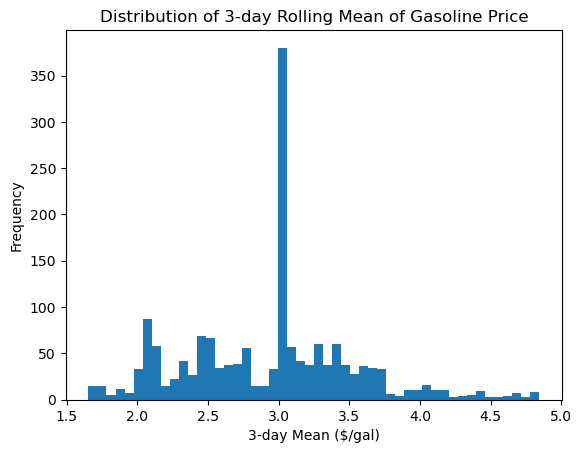

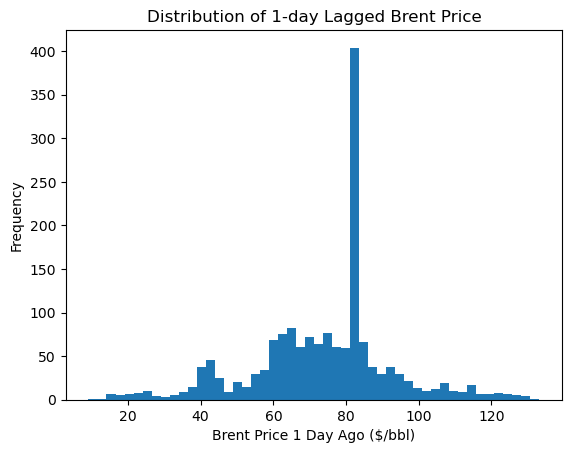

Linear Regression on TSLA:
  • RMSE = 129.144
  • MAE  = 101.625
  • R²   = -1.665


In [30]:
# 1. Pick a target stock to predict (e.g. Tesla)
target = 'TSLA'

# 2. Select your feature columns (all the lag/rolling features + prices)
feature_cols = [c for c in merged_fe.columns
                if c.startswith('Gas_') or c.startswith('Brent_')]

X = merged_fe[feature_cols]
y = merged_fe[target]

# 3. VISUALIZE feature distributions
#    We'll show 3-day rolling-mean of gasoline and 1-day lag of Brent as examples.

# 3a) Gas_roll_mean_3
plt.figure()
plt.hist(merged_fe['Gas_roll_mean_3'], bins=50)
plt.title("Distribution of 3-day Rolling Mean of Gasoline Price")
plt.xlabel("3-day Mean ($/gal)")
plt.ylabel("Frequency")
plt.show()

# 3b) Brent_lag_1
plt.figure()
plt.hist(merged_fe['Brent_lag_1'], bins=50)
plt.title("Distribution of 1-day Lagged Brent Price")
plt.xlabel("Brent Price 1 Day Ago ($/bbl)")
plt.ylabel("Frequency")
plt.show()


# 4. SPLIT into train & test
#    Use an 80/20 split, no shuffling (time series)
split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# 5. BASELINE MODEL: Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# 6. PREDICT & EVALUATE
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(    y_test, y_pred)

print(f"Linear Regression on {target}:")
print(f"  • RMSE = {rmse:.3f}")
print(f"  • MAE  = {mae:.3f}")
print(f"  • R²   = {model.score(X_test, y_test):.3f}")

In [31]:
# --- 1) Engineer stock-specific features for TSLA ---
for lag in [1,2,3]:
    merged_fe[f'TSLA_lag_{lag}'] = merged_fe['TSLA'].shift(lag)

# 1-day % return
merged_fe['TSLA_ret_1'] = merged_fe['TSLA'].pct_change(1)

# 7-day rolling volatility of returns
merged_fe['TSLA_vol_7'] = merged_fe['TSLA_ret_1'].rolling(7).std()

# Drop rows with any NaNs (from shift/pct_change/rolling)
df_model = merged_fe.dropna()

/var/folders/n7/sn8w6zgn143919fscz6p_xnm0000gn/T/ipykernel_62479/1004843680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_fe[f'TSLA_lag_{lag}'] = merged_fe['TSLA'].shift(lag)
/var/folders/n7/sn8w6zgn143919fscz6p_xnm0000gn/T/ipykernel_62479/1004843680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_fe[f'TSLA_lag_{lag}'] = merged_fe['TSLA'].shift(lag)
/var/folders/n7/sn8w6zgn143919fscz6p_xnm0000gn/T/ipykernel_62479/1004843680.py:3: SettingWithCopyWarning: 
A value is trying to be set o

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_squared_error, mean_absolute_error
import numpy as np

# Features = energy features + our new TSLA history features
feature_cols = [c for c in df_model.columns 
                if c.startswith('Gas_') 
                or c.startswith('Brent_')
                or c.startswith('TSLA_lag_')
                or c=='TSLA_ret_1'
                or c=='TSLA_vol_7']

X = df_model[feature_cols]
y = df_model['TSLA']

# 80/20 time-series split
split = int(len(X)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Fit & evaluate
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = model.score(X_test, y_test)

print(f"New Linear Regression on TSLA:")
print(f" • RMSE = {rmse:.3f}")
print(f" • MAE  = {mae:.3f}")
print(f" • R²   = {r2:.3f}")


New Linear Regression on TSLA:
 • RMSE = 5.422
 • MAE  = 3.449
 • R²   = 0.995


In [33]:
from sklearn.ensemble    import RandomForestRegressor
from sklearn.metrics     import mean_squared_error, mean_absolute_error
import numpy as np

# Use the same train/test split from df_model
rf = RandomForestRegressor(n_estimators=100, 
                           max_depth=5, 
                           random_state=42,
                           n_jobs=-1)
rf.fit(X_train, y_train)

y_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_rf))
mae_rf  = mean_absolute_error(y_test, y_rf)
r2_rf   = rf.score(X_test, y_test)

print("Random Forest on TSLA:")
print(f" • RMSE = {rmse_rf:.3f}")
print(f" • MAE  = {mae_rf:.3f}")
print(f" • R²   = {r2_rf:.3f}")

Random Forest on TSLA:
 • RMSE = 17.026
 • MAE  = 9.864
 • R²   = 0.954


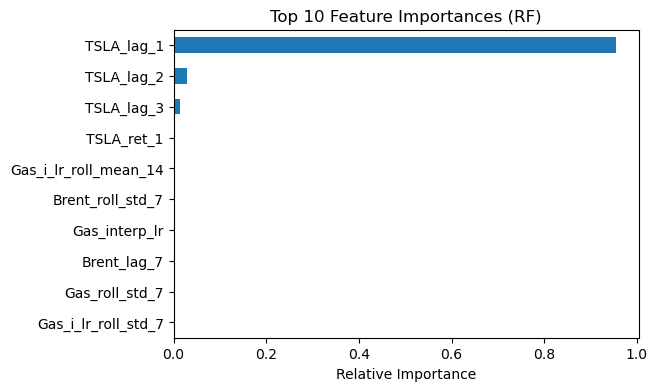

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract and sort importances
imp = pd.Series(rf.feature_importances_, index=feature_cols)
imp = imp.sort_values(ascending=False).head(10)

# Plot top‐10
plt.figure(figsize=(6,4))
imp.plot.barh()
plt.title("Top 10 Feature Importances (RF)")
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()
plt.show()

In [35]:
# Target = TSLA_ret_1
y_ret = df_model['TSLA_ret_1'].dropna()
X_ret = df_model.loc[y_ret.index, feature_cols]  # align indices

# Re-split chronologically
split = int(len(X_ret)*0.8)
Xr_train, Xr_test = X_ret.iloc[:split], X_ret.iloc[split:]
yr_train, yr_test = y_ret.iloc[:split], y_ret.iloc[split:]

# Fit RF again
rf_ret = RandomForestRegressor(100, max_depth=5, random_state=42)
rf_ret.fit(Xr_train, yr_train)
pred_ret = rf_ret.predict(Xr_test)

# Evaluate
rmse_r = np.sqrt(mean_squared_error(yr_test, pred_ret))
mae_r  = mean_absolute_error(    yr_test, pred_ret)
r2_r   = rf_ret.score(Xr_test, yr_test)

print("RF on TSLA Returns:")
print(f" • RMSE = {rmse_r:.4f}")
print(f" • MAE  = {mae_r:.4f}")
print(f" • R²   = {r2_r:.3f}")

In [ ]:
ev_tickers   = ['AYRO','CENN','EVTV','FUV','KNDI','NIO','TSLA','WKHS']
auto_tickers = ['F','GM','HMC','HYMTF','MBGAF','NSANY','STLA','TM','VWAGY']  # adjust to your exact set

# Compute daily sector “price” as the mean across tickers
merged['EV_index']   = merged[ev_tickers].mean(axis=1)
merged['Auto_index'] = merged[auto_tickers].mean(axis=1)

In [ ]:
df_sect = merged.copy()

# 2a) Lagged price, returns & rolling vol for the index
for lag in [1,2,3]:
    df_sect[f'EVidx_lag_{lag}'] = df_sect['EV_index'].shift(lag)

df_sect['EVidx_ret_1']  = df_sect['EV_index'].pct_change(1)
df_sect['EVidx_vol_7']  = df_sect['EVidx_ret_1'].rolling(7).std()

# 2b) Keep the energy‐price features we built earlier
feat_energy = [c for c in df_sect.columns if c.startswith('Gas_') or c.startswith('Brent_')]
feat_evidx  = [c for c in df_sect.columns if c.startswith('EVidx_')]

# Drop NaNs
df_sect = df_sect.dropna(subset=feat_energy + feat_evidx + ['EV_index'])

In [ ]:
X = df_sect[feat_energy + feat_evidx]
y = df_sect['EV_index']

# chronological 80/20 split
split = int(len(X)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# — Linear Regression —
lr = LinearRegression().fit(X_train, y_train)
y_lr = lr.predict(X_test)
print("LR on EV_index:",
      f"RMSE={np.sqrt(mean_squared_error(y_test,y_lr)):.3f}",
      f"R²={lr.score(X_test,y_test):.3f}")

# — Random Forest —
rf = RandomForestRegressor(100, max_depth=5, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
print("RF on EV_index:",
      f"RMSE={np.sqrt(mean_squared_error(y_test,y_rf)):.3f}",
      f"R²={rf.score(X_test,y_test):.3f}")

LR on EV_index: RMSE=187.891 R²=-505.991


RF on EV_index: RMSE=37.809 R²=-19.529


In [ ]:
# --- 1) Compute the Auto sector index ---
auto_tickers = ['F','GM','HMC','HYMTF','MBGAF','NSANY','STLA','TM','VWAGY']  # adjust as needed
merged['Auto_index'] = merged[auto_tickers].mean(axis=1)

# --- 2) Engineer features on the Auto_index ---
df_auto = merged.copy()

# 2a) Lagged price for Auto_index
for lag in [1, 2, 3]:
    df_auto[f'Autoidx_lag_{lag}'] = df_auto['Auto_index'].shift(lag)

# 2b) 1-day return and 7-day rolling vol for Auto_index
df_auto['Autoidx_ret_1'] = df_auto['Auto_index'].pct_change(1)
df_auto['Autoidx_vol_7'] = df_auto['Autoidx_ret_1'].rolling(7).std()

# 2c) Keep the existing energy features
feat_energy = [c for c in df_auto.columns if c.startswith('Gas_') or c.startswith('Brent_')]
feat_autoidx = [c for c in df_auto.columns if c.startswith('Autoidx_')]

# 2d) Drop any rows with NaNs in our feature or target columns
df_auto = df_auto.dropna(subset=feat_energy + feat_autoidx + ['Auto_index'])

# --- 3) Train/Test split & Baseline models ---
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_squared_error
import numpy as np

X = df_auto[feat_energy + feat_autoidx]
y = df_auto['Auto_index']

# chronological 80/20 split
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# — Linear Regression —
lr = LinearRegression().fit(X_train, y_train)
y_lr = lr.predict(X_test)
print("LR on Auto_index:",
      f"RMSE={np.sqrt(mean_squared_error(y_test, y_lr)):.3f}",
      f"R²={lr.score(X_test, y_test):.3f}")

# — Random Forest —
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=5,
                           random_state=42,
                           n_jobs=-1)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
print("RF on Auto_index:",
      f"RMSE={np.sqrt(mean_squared_error(y_test, y_rf)):.3f}",
      f"R²={rf.score(X_test, y_test):.3f}")


LR on Auto_index: RMSE=0.183 R²=0.998
RF on Auto_index: RMSE=2.581 R²=0.589


In [ ]:
# Create return targets for the EV index
df_sect['EVidx_ret_1'] = df_sect['EV_index'].pct_change(1)
df_sect = df_sect.dropna(subset=feat_energy + feat_evidx + ['EVidx_ret_1'])
X = df_sect[feat_energy + feat_evidx]
y = df_sect['EVidx_ret_1']


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble        import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics         import mean_squared_error, mean_absolute_error

# — 1) Prepare your feature matrix X and return target y —
# Assume you already have df_sect with columns feat_energy + feat_evidx and 'EVidx_ret_1'

X = df_sect[feat_energy + feat_evidx]
y = df_sect['EVidx_ret_1']

# — 2) Define a TimeSeriesSplit for CV (no shuffling) —
tscv = TimeSeriesSplit(n_splits=5)

# — 3) Set up the HGB model and hyperparameter grid —
hgb = HistGradientBoostingRegressor(random_state=42)

param_grid = {
    'max_iter':      [100, 300],       # number of boosting iterations
    'max_depth':     [3, 5, 8],        # tree depth
    'learning_rate': [0.01, 0.1],      # step size shrinkage
    'min_samples_leaf': [20, 50],      # min samples per leaf
}

# — 4) Wrap in GridSearchCV —
grid = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# — 5) Fit on your full series (CV happens internally) —
grid.fit(X, y)

print("→ Best CV MSE (neg):", grid.best_score_)
print("→ Best hyperparameters:", grid.best_params_)

# — 6) Final evaluation on hold-out 20% (chronological) —
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

best_model = grid.best_estimator_
pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = best_model.score(X_test, y_test)

print(f"\nHold-out Results on EVidx returns:")
print(f" • RMSE = {rmse:.5f}")
print(f" • MAE  = {mae:.5f}")
print(f" • R²   = {r2:.3f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


→ Best CV MSE (neg): -0.0004525996982055095
→ Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 20}

Hold-out Results on EVidx returns:
 • RMSE = 0.00507
 • MAE  = 0.00226
 • R²   = 0.985


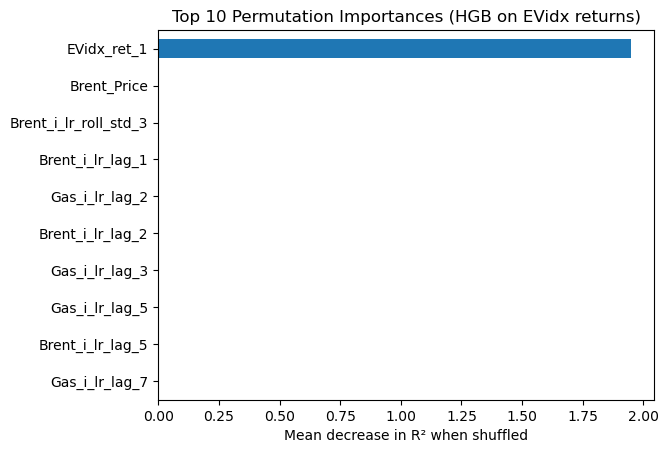

EVidx_ret_1              1.947355
Brent_Price              0.000000
Brent_i_lr_roll_std_3    0.000000
Brent_i_lr_lag_1         0.000000
Gas_i_lr_lag_2           0.000000
Brent_i_lr_lag_2         0.000000
Gas_i_lr_lag_3           0.000000
Gas_i_lr_lag_5           0.000000
Brent_i_lr_lag_5         0.000000
Gas_i_lr_lag_7           0.000000
dtype: float64


In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# — 1) Compute permutation importances on your test set —
# (assuming X_test, y_test from your hold-out split)
perm = permutation_importance(
    best_model,         # your tuned HGB regressor
    X_test,             # features for hold-out
    y_test,             # true returns
    n_repeats=10,       # shuffle each feature 10×
    random_state=42,
    n_jobs=-1
)

# — 2) Build a Series and sort —
feat_names = feat_energy + feat_evidx
imp = pd.Series(perm.importances_mean, index=feat_names)
imp = imp.sort_values(ascending=False)

# — 3) Plot top 10 —
plt.figure()
imp.head(10).plot.barh()
plt.title("Top 10 Permutation Importances (HGB on EVidx returns)")
plt.xlabel("Mean decrease in R² when shuffled")
plt.gca().invert_yaxis()
plt.show()

# — (Optional) print the values —
print(imp.head(10))


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics  import mean_squared_error, mean_absolute_error

# 1) Build X_ablation using ONLY the EV‐index features:
#    (we assume df_sect already exists with your EVidx_* columns and 'EVidx_ret_1')
ablation_feats = [c for c in df_sect.columns if c.startswith('EVidx_')]

X_ab = df_sect[ablation_feats]
y_ab = df_sect['EVidx_ret_1']

# 2) Chronological 80/20 split
split = int(len(X_ab) * 0.8)
X_tr, X_te = X_ab.iloc[:split], X_ab.iloc[split:]
y_tr, y_te = y_ab.iloc[:split], y_ab.iloc[split:]

# 3) Fit the same tuned model (no energy features)
ab_model = HistGradientBoostingRegressor(**best_params, random_state=42)
ab_model.fit(X_tr, y_tr)

# 4) Evaluate
pred_ab = ab_model.predict(X_te)
rmse_ab = np.sqrt(mean_squared_error(y_te, pred_ab))
mae_ab  = mean_absolute_error(y_te, pred_ab)

print(f"Ablation (no oil/gas) — RMSE: {rmse_ab:.5f}, MAE: {mae_ab:.5f}")

NameError: name 'best_params' is not defined

In [ ]:
import shap

# 1) Fit your final model (e.g. best_xgb from earlier)
model = best_model  # or best_model if using HistGradientBoostingRegressor
# 3) Compute SHAP values on your hold-out set
explainer = shap.Explainer(best_model, X_train) # from your train/test split
shap_values = explainer.shap_values(X_holdout)

# 4a) Global feature importance: mean(|SHAP|)
shap.summary_plot(
    shap_values, 
    X_holdout, 
    plot_type="bar",
    max_display=10
)

# 4b) Group by commodity
brent_feats = [c for c in X_holdout.columns if c.startswith('Brent_')]
gas_feats   = [c for c in X_holdout.columns if c.startswith('Gas_')]

mean_shap = np.abs(shap_values).mean(axis=0)
importances = pd.Series(mean_shap, index=X_holdout.columns)
agg = {
    'Brent total': importances[brent_feats].sum(),
    'Gas total':   importances[gas_feats].sum()
}
print(pd.Series(agg))

# 5) Detailed beeswarm for top features
shap.summary_plot(shap_values, X_holdout)

NameError: name 'best_model' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble        import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics         import mean_squared_error, mean_absolute_error

# — 0) Ensure Auto_index & features exist —
auto_tickers = ['F','GM','HMC','HYMTF','MBGAF','NSANY','STLA','TM','VWAGY']
merged['Auto_index'] = merged[auto_tickers].mean(axis=1)

# Build df_auto with energy & index‐history features
df_auto = merged.copy()
for lag in [1,2,3]:
    df_auto[f'Autoidx_lag_{lag}'] = df_auto['Auto_index'].shift(lag)
df_auto['Autoidx_ret_1'] = df_auto['Auto_index'].pct_change(1)
df_auto['Autoidx_vol_7'] = df_auto['Autoidx_ret_1'].rolling(7).std()

feat_energy  = [c for c in df_auto.columns if c.startswith('Gas_') or c.startswith('Brent_')]
feat_autoidx = [c for c in df_auto.columns if c.startswith('Autoidx_')]
df_auto = df_auto.dropna(subset=feat_energy + feat_autoidx + ['Autoidx_ret_1'])

# — 1) Prepare X and y for CV/hold-out —
X = df_auto[feat_energy + feat_autoidx]
y = df_auto['Autoidx_ret_1']

# — 2) Time-series CV setup —
tscv = TimeSeriesSplit(n_splits=5)

# — 3) Define model + hyperparameter grid —
hgb = HistGradientBoostingRegressor(random_state=42)
param_grid = {
    'max_iter':         [100, 300],
    'max_depth':        [3, 5, 8],
    'learning_rate':    [0.01, 0.1],
    'min_samples_leaf': [20, 50],
}

# — 4) GridSearchCV over CV folds —
grid = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid.fit(X, y)

print("→ Best CV MSE (neg):", grid.best_score_)
print("→ Best hyperparameters:", grid.best_params_)

# — 5) Chronological 80/20 hold-out evaluation —
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = best_model.score(X_test, y_test)

print(f"\nHold-out Results on Autoidx returns:")
print(f" • RMSE = {rmse:.5f}")
print(f" • MAE  = {mae:.5f}")
print(f" • R²   = {r2:.3f}")

# — 6) Ablation test: drop oil/gas features —
X_ab = df_auto[feat_autoidx]
X_tr_ab, X_te_ab = X_ab.iloc[:split], X_ab.iloc[split:]
y_tr_ab, y_te_ab = y_train, y_test

ab_model = HistGradientBoostingRegressor(**grid.best_params_, random_state=42)
ab_model.fit(X_tr_ab, y_tr_ab)
y_ab = ab_model.predict(X_te_ab)

rmse_ab = np.sqrt(mean_squared_error(y_te_ab, y_ab))
mae_ab  = mean_absolute_error(y_te_ab, y_ab)

print(f"\nAblation (no oil/gas) — RMSE: {rmse_ab:.5f}, MAE: {mae_ab:.5f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
→ Best CV MSE (neg): -2.846050869627914e-05
→ Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 20}

Hold-out Results on Autoidx returns:
 • RMSE = 0.00112
 • MAE  = 0.00033
 • R²   = 0.994

Ablation (no oil/gas) — RMSE: 0.00301, MAE: 0.00053


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.9/546.9 kB 7.2 MB/s eta 0:00:00a 0:00:01


In [ ]:

# 1) Prepare your feature matrix X and target y (as before)
#    Make sure you’ve excluded EVidx_ret_1 from your X!
feat_gas   = [c for c in merged_fe.columns if c.startswith('Gas_i_lr_')]
feat_brent = [c for c in merged_fe.columns if c.startswith('Brent_i_lr_')]
feat_ev    = [c for c in merged_fe.columns if c.startswith('EVidx_') and c!='EVidx_ret_1']
X = merged_fe[feat_gas + feat_brent + feat_ev]
y = merged_fe['EVidx_ret_1']

# 2) Time-series CV splitter
tscv = TimeSeriesSplit(n_splits=5)

# 3) Set up XGBRegressor and a hyperparameter grid
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, tree_method='hist')
param_grid = {
    'n_estimators':    [100, 300, 500],
    'max_depth':       [3, 5, 8],
    'learning_rate':   [0.01, 0.1],
    'subsample':       [0.7, 1.0],
    'colsample_bytree':[0.7, 1.0],
    'reg_alpha':       [0, 0.1],       # L1 regularization
    'reg_lambda':      [1, 5],         # L2 regularization
}

# 4) GridSearchCV over your time splits
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# 5) Fit on the full series (CV happens inside)
grid_xgb.fit(X, y)
print("→ Best CV MSE (neg):", grid_xgb.best_score_)
print("→ Best hyperparameters:", grid_xgb.best_params_)

# 6) Hold-out evaluation (last 20% of dates)
split = int(len(X) * 0.8)
X_tr, X_te = X.iloc[:split], X.iloc[split:]
y_tr, y_te = y.iloc[:split], y.iloc[split:]

best_xgb = grid_xgb.best_estimator_
y_pred   = best_xgb.predict(X_te)

rmse = np.sqrt(mean_squared_error(y_te, y_pred))
mae  = mean_absolute_error(y_te, y_pred)
r2   = best_xgb.score(X_te, y_te)

print("\nHold-out Results on EVidx returns with XGBoost:")
print(f" • RMSE = {rmse:.5f}")
print(f" • MAE  = {mae:.5f}")
print(f" • R²   = {r2:.3f}")

KeyError: 'EVidx_ret_1'

# Unused electrcity Data
tested electrcity which just created noise

In [ ]:
!pip install pandas-datareader

In [ ]:
# 1. Install & import the reader
#    pip install pandas-datareader
import pandas_datareader.data as web

# 2. Set your date range
start, end = '2018-09-01', '2025-05-01'

# 3. Pull APU000072610 from FRED
elec = web.DataReader('APU000072610', 'fred', start, end)

# 4. Rename for clarity
elec = elec.rename(columns={'APU000072610': 'Elec_Price'})

# 5. Inspect
print(elec.head())


            Elec_Price
DATE                  
2018-09-01       0.138
2018-10-01       0.136
2018-11-01       0.134
2018-12-01       0.135
2019-01-01       0.135


In [ ]:
# 1) Make sure the index is datetime and reindex to your business‐day index bidx
elec.index = pd.to_datetime(elec.index)
elec_daily = elec.reindex(bidx).ffill()

# 2) Merge into your merged DataFrame
merged = merged.join(elec_daily, how='inner')

# 3) Now you’ll have Elec_Price on every trading day; you can engineer features:
merged['Elec_ret_1'] = merged['Elec_Price'].pct_change(1)
for lag in [1,2,3]:
    merged[f'Elec_lag_{lag}'] = merged['Elec_Price'].shift(lag)
for w in [7,14]:
    merged[f'Elec_roll_mean_{w}'] = merged['Elec_Price'].rolling(w).mean()
    merged[f'Elec_roll_std_{w}']  = merged['Elec_Price'].rolling(w).std()

# 4) Drop any rows that now contain NaNs
merged = merged.dropna()

In [ ]:
feat_elec = [c for c in merged.columns if c.startswith('Elec_')]


In [ ]:
df_sect = merged.copy()

# --- 2) (Re-)create the EV‐index history features ---
# you probably already ran this before, but do it again on the fresh df_sect
for lag in [1,2,3]:
    df_sect[f'EVidx_lag_{lag}'] = df_sect['EV_index'].shift(lag)
df_sect['EVidx_ret_1'] = df_sect['EV_index'].pct_change(1)
df_sect['EVidx_vol_7'] = df_sect['EVidx_ret_1'].rolling(7).std()

# --- 3) Define your feature groups, now including electricity ---
feat_energy = [c for c in df_sect.columns if c.startswith('Gas_') or c.startswith('Brent_')]
feat_evidx  = [c for c in df_sect.columns if c.startswith('EVidx_')]
feat_elec   = [c for c in df_sect.columns if c.startswith('Elec_')]

# --- 4) Drop any rows with NaNs in your chosen features + target ---
df_sect = df_sect.dropna(subset=feat_energy + feat_evidx + feat_elec + ['EVidx_ret_1'])

# --- 5) Build X and y from this updated df_sect ---
X = df_sect[feat_energy + feat_evidx + feat_elec]
y = df_sect['EVidx_ret_1']

In [ ]:
# — 2) Define a TimeSeriesSplit for CV (no shuffling) —
tscv = TimeSeriesSplit(n_splits=5)

# — 3) Set up the HGB model and hyperparameter grid —
hgb = HistGradientBoostingRegressor(random_state=42)

param_grid = {
    'max_iter':      [100, 300],       # number of boosting iterations
    'max_depth':     [3, 5, 8],        # tree depth
    'learning_rate': [0.01, 0.1],      # step size shrinkage
    'min_samples_leaf': [20, 50],      # min samples per leaf
}

# — 4) Wrap in GridSearchCV —
grid = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# — 5) Fit on your full series (CV happens internally) —
grid.fit(X, y)

print("→ Best CV MSE (neg):", grid.best_score_)
print("→ Best hyperparameters:", grid.best_params_)

# — 6) Final evaluation on hold-out 20% (chronological) —
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

best_model = grid.best_estimator_
pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = best_model.score(X_test, y_test)

print(f"\nHold-out Results on EVidx returns:")
print(f" • RMSE = {rmse:.5f}")
print(f" • MAE  = {mae:.5f}")
print(f" • R²   = {r2:.3f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


→ Best CV MSE (neg): -0.00047179221602101126
→ Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 20}

Hold-out Results on EVidx returns:
 • RMSE = 0.00516
 • MAE  = 0.00226
 • R²   = 0.985
